In [1]:
from netCDF4 import Dataset                     # Read / Write NetCDF4 files
import matplotlib.pyplot as plt                 # Plotting library
from datetime import datetime                   # Basic Dates and time types
import cartopy, cartopy.crs as ccrs             # Plot maps
import os                                       # Miscellaneous operating system interfaces
from osgeo import osr                           # Python bindings for GDAL
from osgeo import gdal                          # Python bindings for GDAL
import numpy as np                              # Scientific computing with Python

def plot_derived_instability_index(extent, var, file_name):

    band = '13'

    # Open the file
    img = gdal.Open(f'NETCDF:../data/goes16/{file_name}.nc:' + var)

    # Read the header metadata
    metadata = img.GetMetadata()
    scale = float(metadata.get(var + '#scale_factor'))
    offset = float(metadata.get(var + '#add_offset'))
    undef = float(metadata.get(var + '#_FillValue'))
    dtime = metadata.get('NC_GLOBAL#time_coverage_start')

    print(f'scale/offset/undef/dtime: {scale}/{offset}/{undef}/{dtime}')

    # Load the data
    ds = img.ReadAsArray(0, 0, img.RasterXSize, img.RasterYSize).astype(float)

    # Apply the scale, offset and convert to celsius
    ds = (ds * scale + offset)

    # Read the original file projection and configure the output projection
    source_prj = osr.SpatialReference()
    source_prj.ImportFromProj4(img.GetProjectionRef())

    target_prj = osr.SpatialReference()
    target_prj.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

    # Reproject the data
    GeoT = img.GetGeoTransform()
    driver = gdal.GetDriverByName('MEM')
    raw = driver.Create('raw', ds.shape[0], ds.shape[1], 1, gdal.GDT_Float32)
    raw.SetGeoTransform(GeoT)
    raw.GetRasterBand(1).WriteArray(ds)

    # Define the parameters of the output file
    options = gdal.WarpOptions(format = 'netCDF',
            srcSRS = source_prj,
            dstSRS = target_prj,
            outputBounds = (extent[0], extent[3], extent[2], extent[1]),
            outputBoundsSRS = target_prj,
            outputType = gdal.GDT_Float32,
            srcNodata = undef,
            dstNodata = 'nan',
            xRes = 0.02,
            yRes = 0.02,
            resampleAlg = gdal.GRA_NearestNeighbour)

    print(options)

    # Write the reprojected file on disk
    gdal.Warp(f'../data/goes16/{file_name}_ret.nc', raw, options=options)
    #-----------------------------------------------------------------------------------------------------------
    # Open the reprojected GOES-R image
    file = Dataset(f'../data/goes16/{file_name}_ret.nc')

    print(f'file.variables = {file.variables}')

    # Get the pixel values
    data = file.variables['Band1'][:]

    #-----------------------------------------------------------------------------------------------------------
    # Choose the plot size (width x height, in inches)
    plt.figure(figsize=(10,10))

    # Use the Geostationary projection in cartopy
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Define the image extent
    img_extent = [extent[0], extent[2], extent[1], extent[3]]

    # Define the color scale based on the channel
    colormap = "jet" # White to black for IR channels
    # colormap = "gray_r" # White to black for IR channels

    # Plot the image
    img = ax.imshow(data, origin='upper', extent=img_extent, cmap=colormap)

    # Add coastlines, borders and gridlines
    ax.coastlines(resolution='10m', color='black', linewidth=0.8)
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='gray', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

    # Add a colorbar
    plt.colorbar(img, label=var, extend='both', orientation='horizontal', pad=0.05, fraction=0.05)

    # Extract date
    date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

    # Add a title
    plt.title('GOES-16 ' + var + ' ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC', fontweight='bold', fontsize=10, loc='left')
    plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')


    #-----------------------------------------------------------------------------------------------------------
    # Save the image
    plt.savefig(f'../data/goes16/{file_name}_{var}.png', bbox_inches='tight', pad_inches=0, dpi=300)

    # Show the image
    plt.show()

/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


scale/offset/undef/dtime: 0.076300927/0.0/65535.0/2022-04-01T17:00:20.5Z
(<osgeo.gdal.GDALWarpAppOptions; proxy of <Swig Object of type 'GDALWarpAppOptions *' at 0x7f86bc173450> >, None, None)
file.variables = {'Band1': <class 'netCDF4._netCDF4.Variable'>
float32 Band1(lat, lon)
    long_name: GDAL Band Number 1
    _FillValue: nan
    grid_mapping: crs
unlimited dimensions: 
current shape = (1000, 1450)
filling on, 'crs': <class 'netCDF4._netCDF4.Variable'>
|S1 crs()
    grid_mapping_name: latitude_longitude
    long_name: CRS definition
    longitude_of_prime_meridian: 0.0
    semi_major_axis: 6378137.0
    inverse_flattening: 298.257223563
    spatial_ref: GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
    crs_wkt: GEOGCS["unknown",DATUM["WGS_1984",SPHERO

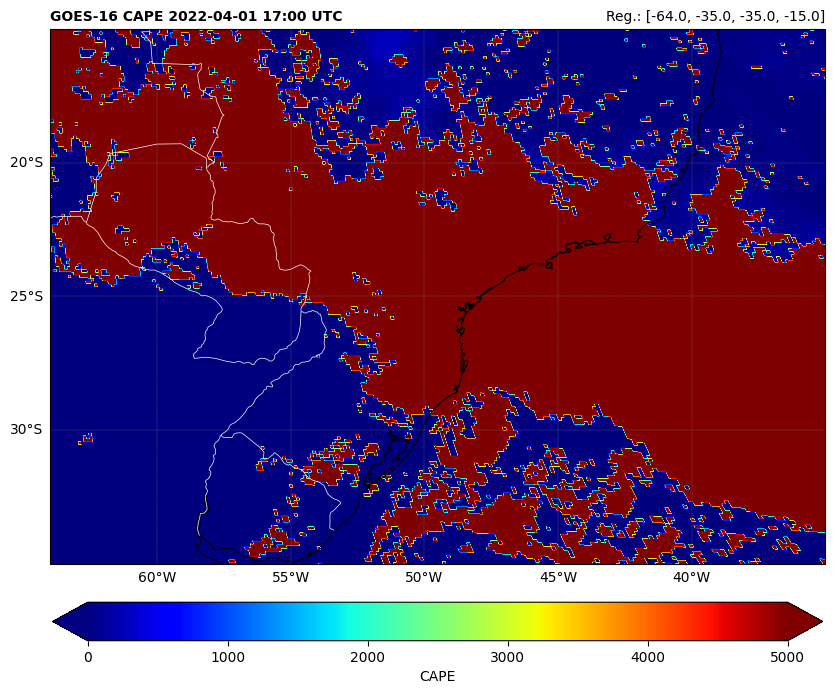

In [2]:
# Desired extent
extent = [-64.0, -35.0, -35.0, -15.0] # Min lon, Min lat, Max lon, Max lat
# extent = [-44.0, -23.0, -43.0, -22.0]  # Min lon, Min lat, Max lon, Max lat --> Rio de Janeiro

# Options:
# - Convective Available Potential Energy (CAPE)
# - Lifted Index (LI)
# - Total Totals (TT)
# - Showalter Index (SI)
# - K-index (KI)
var = 'CAPE'

# Downloaded file
file_name = 'OR_ABI-L2-DSIF-M6_G16_s20220911700205_e20220911709513_c20220911711480'

plot_derived_instability_index(extent, var, file_name)